In [31]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [32]:
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.utils import draw_bounding_boxes
from albumentations.pytorch import ToTensorV2
from torchvision.ops.boxes import box_iou
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import xml.etree.ElementTree as ET
from pycocotools.coco import COCO
import albumentations as A
from PIL import Image
import pandas as pd
import torchvision
from tqdm import tqdm 
import numpy as np
import matplotlib as plt
import torch
import json
import copy
import math
import cv2


In [33]:



'''def pascal_voc_to_coco(voc_dir, coco_dir):
    if not os.path.exists(coco_dir):
        os.makedirs(coco_dir)

    coco_annotations = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    category_mapping = {}
    annotation_id = 1

    for xml_file in os.listdir(voc_dir):
        if not xml_file.endswith('.xml'):
            continue

        tree = ET.parse(os.path.join(voc_dir, xml_file))
        root = tree.getroot()

        filename = root.find('filename').text
        image_path = os.path.join(voc_dir, filename)
        if not os.path.exists(image_path):
            continue

        image = Image.open(image_path)
        width, height = image.size
        image_id = len(coco_annotations["images"]) + 1

        coco_annotations["images"].append({
            "id": image_id,
            "file_name": filename,
            "width": width,
            "height": height
        })

        image.save(os.path.join(coco_dir, filename))

        for obj in root.findall('object'):
            category = obj.find('name').text
            if category not in category_mapping:
                category_id = len(category_mapping) + 1
                category_mapping[category] = category_id
                coco_annotations["categories"].append({
                    "id": category_id,
                    "name": category
                })
            else:
                category_id = category_mapping[category]

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            coco_annotations["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": [xmin, ymin, xmax - xmin, ymax - ymin],
                "area": (xmax - xmin) * (ymax - ymin),
                "iscrowd": 0
            })
            annotation_id += 1

    with open(os.path.join(coco_dir, 'annotations.json'), 'w') as f:
        json.dump(coco_annotations, f, indent=4)'''

#Modified code to handle VOC_2007 xml structure
def pascal_voc_to_coco(voc_annotation_dir, voc_image_dir, coco_dir, max_files=10):
    if not os.path.exists(coco_dir):
        os.makedirs(coco_dir)

    coco_annotations = {"images": [], "annotations": [], "categories": []}
    category_mapping = {}
    annotation_id = 1

    xml_files = [f for f in os.listdir(voc_annotation_dir) if f.endswith('.xml')]
    print(f"🔍 Found {len(xml_files)} XML annotation files.")

    if len(xml_files) == 0:
        print("❌ No XML files found. Check your VOC dataset path.")
        return

    for idx, xml_file in enumerate(xml_files):
        xml_path = os.path.join(voc_annotation_dir, xml_file)

        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
        except Exception as e:
            print(f"❌ Error parsing {xml_file}: {e}")
            continue

        filename = root.find('filename').text  # e.g., '000005.jpg'
        
        # Check if the image exists
        image_path = None
        for ext in [".jpg", ".jpeg", ".png"]:
            temp_path = os.path.join(voc_image_dir, filename.replace(".jpg", ext))
            if os.path.exists(temp_path):
                image_path = temp_path
                break

        if image_path is None:
            print(f"⚠️ Warning: Image {filename} not found in {voc_image_dir}. Skipping...")
            continue

        # Load image size
        image = Image.open(image_path)
        width, height = image.size
        image_id = idx + 1

        coco_annotations["images"].append({
            "id": image_id, "file_name": filename, "width": width, "height": height
        })

        image.save(os.path.join(coco_dir, filename))  # Save images in COCO folder

        for obj in root.findall('object'):
            category = obj.find('name').text
            if category not in category_mapping:
                category_id = len(category_mapping) + 1
                category_mapping[category] = category_id
                coco_annotations["categories"].append({"id": category_id, "name": category})
            else:
                category_id = category_mapping[category]

            bndbox = obj.find('bndbox')
            xmin, ymin, xmax, ymax = (int(bndbox.find(pos).text) for pos in ['xmin', 'ymin', 'xmax', 'ymax'])

            if xmax <= xmin or ymax <= ymin:
                print(f"⚠️ Skipping invalid bbox in {xml_file}: [{xmin}, {ymin}, {xmax}, {ymax}]")
                continue

            coco_annotations["annotations"].append({
                "id": annotation_id, "image_id": image_id, "category_id": category_id,
                "bbox": [xmin, ymin, xmax - xmin, ymax - ymin], "area": (xmax - xmin) * (ymax - ymin), "iscrowd": 0
            })
            annotation_id += 1

    with open(os.path.join(coco_dir, 'annotations_test.json'), 'w') as f:
        json.dump(coco_annotations, f, indent=4)

    print(f"✅ Successfully converted {len(xml_files)} VOC files to COCO format.")



In [34]:
#pascal_voc_to_coco('path_to_voc_dir', 'path_to_coco_dir')

#pascal_voc_to_coco(annotations_dir, images_dir, coco_output_dir, max_files=10)


In [35]:
def preprocess_image(img, bilateral_filter=False, median_filter=False, gaussian_filter=False):
    """
    Preprocess an image by applying specified filters.

    Parameters:
        img_path (str): Path to the input image.
        bilateral_filter (bool): Apply bilateral filter if True.
        median_filter (bool): Apply median filter if True.
        gaussian_filter (bool): Apply Gaussian filter if True.

    Returns:
        processed_img: The processed image after applying the filters.
    """
    # Read the image
    '''mg = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found at the specified path.")'''

    processed_img = img

    # Apply bilateral filter
    if bilateral_filter:
        processed_img = cv2.bilateralFilter(processed_img, d=9, sigmaColor=75, sigmaSpace=75)

    # Apply median filter
    if median_filter:
        processed_img = cv2.medianBlur(processed_img, ksize=5)

    # Apply Gaussian filter
    if gaussian_filter:
        processed_img = cv2.GaussianBlur(processed_img, ksize=(5, 5), sigmaX=0)

    return processed_img    

In [36]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(256, 256),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ColorJitter(p=0.2),
            A.Transpose(p=0.2),
            ToTensorV2()], 
            bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(256, 256),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [55]:
'''class Detection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "annotations.json")) 
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] 
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} 
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) 
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ 
    def __len__(self):
        return len(self.ids)'''

class ObjectDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, preprocess_params=None):
        self.root = root  # Root directory containing images and annotations
        self.split = split
        self.transform = transform
        self.preprocess_params = preprocess_params or {}
        self.coco = COCO(os.path.join(root, split, "annotations.json"))  # No train/valid split
        self.ids = list(sorted(self.coco.imgs.keys()))
        
        # Filter out images with no annotations
        self.ids = [id for id in self.ids if len(self._load_target(id)) > 0]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root,self.split, path))  # Directly in root, not subdir
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        
        #Preprocess function
        if self.preprocess_params:
            image = preprocess_image(image, **self.preprocess_params)
        
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)  # Returns a NumPy array
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes)
            image = transformed['image']
            boxes = transformed['bboxes']

        new_boxes = []  # Convert from xywh to xyxy
        for box in boxes:
            xmin, ymin, w, h, category_id = box
            xmax = xmin + w
            ymax = ymin + h
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {
            'boxes': boxes,
            'labels': torch.tensor([t['category_id'] for t in target], dtype=torch.int64),
            'image_id': torch.tensor([id], dtype=torch.int64),
            'area': (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),
            'iscrowd': torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64),
        }

        # **Convert NumPy image to PyTorch tensor & Change Shape [H, W, C] -> [C, H, W]**
        #image = torch.tensor(image, dtype=torch.float32).permute(1,0,2)  # Convert [H, W, C] → [C, H, W]
        
        
        return image / 255.0, targ  # Normalize image

    def __len__(self):
        return len(self.ids)

In [56]:

preprocess_params = {
     'bilateral_filter': True,  # Apply bilateral filter
     'median_filter': False,    # Do not apply median filter
     'gaussian_filter': True,   # Apply Gaussian filter
}

In [57]:
dataset_path = "/work/qucikml/VOC_2007"


In [58]:
#train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))
#train_dataset = CocoDetection(root=dataset_path, annFile=annotations_file, transform=get_transforms(True))
train_dataset = ObjectDetection(root=dataset_path, split="train", transform=get_transforms(True),preprocess_params=preprocess_params)
# fulltest_dataset = ObjectDetection(root=dataset_path, split="test", transform=None)
val_dataset = ObjectDetection(root=dataset_path,split='test', transform=None)

# Define train-validation split ratio
# val_size = int(0.2 * len(fulltest_dataset))  # 20% for validation
# test_size = len(fulltest_dataset) - val_size

# Split the dataset
# test_dataset, val_dataset = random_split(fulltest_dataset, [test_size, val_size])


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [59]:
'''coco = COCO(os.path.join(dataset_path, "train", "annotations.json"))
categories = coco.cats
n_classes = len(categories.keys())'''
coco = COCO(os.path.join(dataset_path,"train", "annotations.json"))
categories = coco.cats
n_classes = len(categories.keys())+1

print(f"Number of Classes: {n_classes}")


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Number of Classes: 21


In [60]:
#model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=True)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))  
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)  
anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
model.rpn.anchor_generator = anchor_generator
model.rpn.nms_thresh = 0.7
model.roi_heads.nms_thresh = 0.5
model.roi_heads.score_thresh = 0.05
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [61]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [62]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [63]:
train_dataset

Dataset ObjectDetection
    Number of datapoints: 5011
    Root location: /work/qucikml/VOC_2007

In [64]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
#targets = [{k: torch.as_tensor(v, dtype=torch.int64).to(device) for k, v in t.items()} for t in targets]
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) 


In [65]:
# images,targets = next(iter(train_loader))
# print(images[0].shape)




# images = list(image for image in images)
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# targets = [{k:v for k, v in t.items()} for t in targets]
# image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)  # Convert [H, W, C] → [C, H, W]


# print(images[0].shape)'''

# #targets = [{k: torch.as_tensor(v, dtype=torch.int64).to(device) for k, v in t.items()} for t in targets]
# #targets = [{k:v for k, v in t.items()} for t in targets]
# output = model(images, targets) 


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [67]:
model = model.to(device)


In [68]:
def early_stopping(patience=3, min_delta=0.0, restore_best_weights=True, start_from_epoch=0):
    best_loss = float('inf')
    patience_counter = 0
    best_model_weights = None
    
    def check(epoch, val_loss, model):
        nonlocal best_loss, patience_counter, best_model_weights
        
        if epoch < start_from_epoch:
            return False
        
        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            patience_counter = 0
            if restore_best_weights:
                best_model_weights = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                if restore_best_weights and best_model_weights:
                    print("Restoring best model weights...")
                    model.load_state_dict(best_model_weights)
                return True
        return False
    
    return check

In [69]:
stop_early = early_stopping(patience=3, min_delta=0.01, restore_best_weights=True, start_from_epoch=0)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [70]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) 
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") 
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        
    all_losses_dict = pd.DataFrame(all_losses_dict) 
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))
    
    


In [75]:
@torch.no_grad()  # No gradients needed for evaluation
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    for images, targets in loader:
        # Convert NumPy arrays to PyTorch tensors and move to device (without permute)
        images = [torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).to(device) for img in images]
        
        # Get model predictions (model is in eval mode, so it won't return loss)
        outputs = model(images)  

        # Compute validation loss if needed (requires a loss function)
        if "loss_classifier" in outputs[0]:  # Ensure losses exist
            loss_dict = outputs
            loss = sum(loss for loss in loss_dict.values()).item()
        else:
            loss = 0  # If no loss, just set to 0

        total_loss += loss
        num_batches += 1

    return total_loss / max(num_batches, 1)  # Avoid division by zero

In [77]:
num_epochs=5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    
    # Evaluate validation loss    
    val_loss = evaluate(model, val_loader, device)
    
    # Check early stopping condition
    if stop_early(epoch, val_loss, model):
       break
    
  



  0%|          | 0/1253 [00:00<?, ?it/s]/tmp/ipykernel_1741/456005237.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
100%|██████████| 1253/1253 [03:46<00:00,  5.52it/s]


Epoch 0, lr: 0.010000, loss: 0.455589, loss_classifier: 0.215058, loss_box: 0.189796, loss_rpn_box: 0.017772, loss_object: 0.032963
✅ Model saved successfully!


100%|██████████| 1253/1253 [03:48<00:00,  5.49it/s]


Epoch 1, lr: 0.010000, loss: 0.446588, loss_classifier: 0.208826, loss_box: 0.188310, loss_rpn_box: 0.017626, loss_object: 0.031826
✅ Model saved successfully!


100%|██████████| 1253/1253 [03:48<00:00,  5.49it/s]


Epoch 2, lr: 0.001000, loss: 0.382975, loss_classifier: 0.167623, loss_box: 0.176864, loss_rpn_box: 0.015186, loss_object: 0.023302
Early stopping triggered after 3 epochs.
Restoring best model weights...


In [ ]:
torch.save(model.state_dict(), "/work/qucikml/model.pth")
print("✅ Model saved successfully!")
torch.cuda.empty_cache()

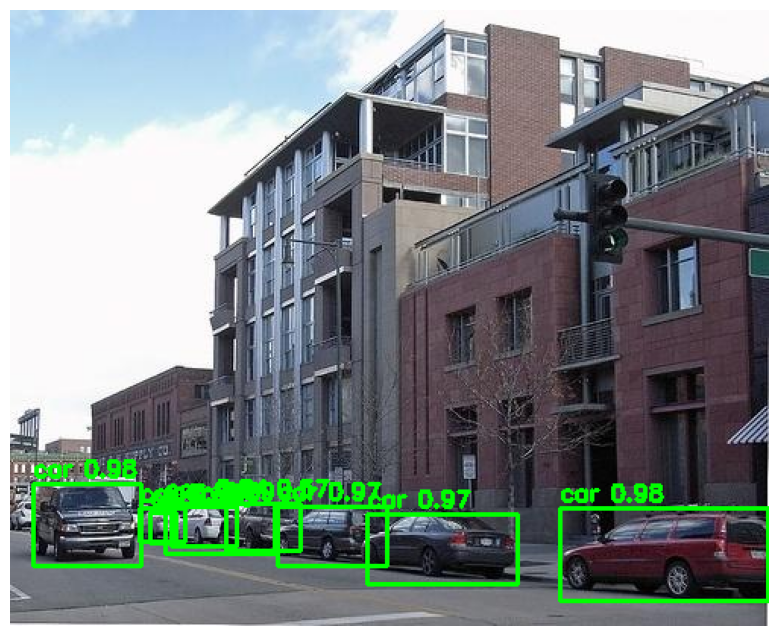

In [91]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the same model architecture as used during training
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Define class labels (modify according to your dataset)
CLASS_NAMES = {
    1: "chair", 2: "car", 3: "horse", 4: "person", 5: "bicycle",
    6: "cat", 7: "dog", 8: "train", 9: "aeroplane",
    10: "diningtable", 11: "tvmonitor", 12: "bird", 13: "bottle", 14: "motorbike",
    15: "pottedplant", 16: "boat", 17: "sofa", 18: "sheep",
    19: "cow", 20: "bus"
}

# Load the trained model correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=21)  # 20 classes + 1 background
model.load_state_dict(torch.load("model.pth", map_location=device))
model.to(device)
model.eval()

# Function to run inference on a single image
def predict_and_visualize(image_path, model, threshold=0.5):
    # Read and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_tensor = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    # Run inference
    with torch.no_grad():
        predictions = model(img_tensor)

    # Extract predictions
    boxes = predictions[0]["boxes"].cpu().numpy()
    labels = predictions[0]["labels"].cpu().numpy()
    scores = predictions[0]["scores"].cpu().numpy()

    # Draw bounding boxes on the image
    for i, box in enumerate(boxes):
        if scores[i] >= threshold:
            x1, y1, x2, y2 = box.astype(int)
            label = CLASS_NAMES.get(labels[i], "Unknown")
            score = scores[i]

            # Draw box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"{label} {score:.2f}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Show the image with detections
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Example usage
image_path = "VOC_2007/test/000004.jpg"  # Update with your image path
predict_and_visualize(image_path, model)


In [ ]:

torch.cuda.empty_cache()


In [ ]:
test_dataset = ObjectDetection(root=dataset_path, split="test", transforms=get_transforms(False))


In [ ]:
def evaluate1(model, loader, device, iou_threshold=0.5):
    model.to(device)
    model.eval()

    all_ap = []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
           

            predictions = model(images)

            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].cpu()
                pred_scores = pred['scores'].cpu()
                pred_labels = pred['labels'].cpu()

                true_boxes = target['boxes'].cpu()
                true_labels = target['labels'].cpu()

                if len(pred_boxes) > 0 and len(true_boxes) > 0:
                    iou_matrix = box_iou(pred_boxes, true_boxes)  
                    max_iou, max_iou_idx = iou_matrix.max(dim=1)  
                    correct = (max_iou > iou_threshold) & (pred_labels == true_labels[max_iou_idx])
                    ap = correct.float().sum() / max(1, len(true_boxes))  
                else:
                    ap = torch.tensor(0.0)  

                all_ap.append(ap.item())

    mAP = sum(all_ap) / len(all_ap)
    print(f"mAP@{iou_threshold}: {mAP:.4f}")
    return mAP


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [ ]:
mAP_score = evaluate1(model, test_loader, device)


In [ ]:
mAp_score

In [ ]:
!pip install shutil


In [ ]:
import os
import shutil
import random
import json
from pathlib import Path
from tqdm import tqdm

def split_and_copy_data(test_dir, output_dir, annotation_file, split_ratio=0.2):
    """
    Split the test directory into two subdirectories: test1 and val1, with an 80-20 ratio
    and copy the corresponding annotations to new files.
    
    Parameters:
        test_dir (str): Path to the original test directory containing images and annotations.
        output_dir (str): Path to the output directory where test1 and val1 will be created.
        annotation_file (str): Path to the original annotation file (COCO format).
        split_ratio (float): The ratio for the train-val split, default is 0.2 (i.e., 80-20 split).
    """
    # Ensure the output directories exist
    test1_dir = os.path.join(output_dir, 'test1')
    val1_dir = os.path.join(output_dir, 'val1')

    os.makedirs(test1_dir, exist_ok=True)
    os.makedirs(val1_dir, exist_ok=True)

    # Load the annotations file (COCO format)
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)

    # Get all image ids and shuffle them for random selection
    all_image_ids = [image['id'] for image in annotations['images']]
    random.shuffle(all_image_ids)

    # Calculate the split index for the 80-20 split
    split_index = int(len(all_image_ids) * (1 - split_ratio))
    test_image_ids = set(all_image_ids[:split_index])
    val_image_ids = set(all_image_ids[split_index:])

    # Copy the images to the new directories
    for image in tqdm(annotations['images'], desc="Processing Images"):
        image_id = image['id']
        filename = image['file_name']

        # Determine the new directory based on the split
        if image_id in test_image_ids:
            new_image_path = os.path.join(test1_dir, filename)
        else:
            new_image_path = os.path.join(val1_dir, filename)

        # Copy the image to the appropriate directory
        original_image_path = os.path.join(test_dir, filename)
        shutil.copy(original_image_path, new_image_path)

    # Update the annotations for the new directories (test1 and val1)
    new_annotations_test1 = {"images": [], "annotations": [], "categories": annotations['categories']}
    new_annotations_val1 = {"images": [], "annotations": [], "categories": annotations['categories']}

    for image in annotations['images']:
        image_id = image['id']
        filename = image['file_name']

        # Update file paths based on whether the image is in test1 or val1
        if image_id in test_image_ids:
            image['file_name'] = os.path.join('test1', filename)
            new_annotations_test1["images"].append(image)
        else:
            image['file_name'] = os.path.join('val1', filename)
            new_annotations_val1["images"].append(image)

    # Copy the annotations for the images to the appropriate lists
    for annotation in annotations['annotations']:
        image_id = annotation['image_id']
        
        # Add annotations to the respective list based on image id
        if image_id in test_image_ids:
            new_annotations_test1["annotations"].append(annotation)
        else:
            new_annotations_val1["annotations"].append(annotation)

    # Save the updated annotations to new files
    test1_annotations_file = os.path.join(output_dir, 'annotations_test1.json')
    val1_annotations_file = os.path.join(output_dir, 'annotations_val1.json')

    with open(test1_annotations_file, 'w') as f:
        json.dump(new_annotations_test1, f, indent=4)

    with open(val1_annotations_file, 'w') as f:
        json.dump(new_annotations_val1, f, indent=4)

    print(f"✅ Successfully created 'test1' and 'val1' directories with {len(test_image_ids)} test and {len(val_image_ids)} val images.")

# Example usage
test_directory = '/work/qucikml/VOC_2007/test'  # Replace with your test directory
output_directory = '/work/qucikml/VOC_2008'  # Replace with your output directory
annotations_file = '/work/qucikml/VOC_2007/test/annotations.json'  # Path to the annotations file

# Call the function to split the data and copy the images and annotations
split_and_copy_data(test_directory, output_directory, annotations_file)


In [35]:
import json
import os

# Path to your existing annotation file
annotation_file = "/work/qucikml/VOC_2007/val/annotations.json"  # Change this to your actual path

# Load the JSON file
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# Modify the file_name field
for image in annotations["images"]:
    image["file_name"] = os.path.basename(image["file_name"])  # Keep only the filename

# Save the updated annotation file
updated_annotation_file = "/work/qucikml/VOC_2007/val/annotations_val1_fixed.json"  # Change as needed
with open(updated_annotation_file, "w") as f:
    json.dump(annotations, f, indent=4)

print(f"✅ Updated annotation file saved at: {updated_annotation_file}")


✅ Updated annotation file saved at: /work/qucikml/VOC_2007/val/annotations_val1_fixed.json


In [95]:
import json

# Correct class mapping (provided by you)
CLASS_NAMES = {
    1: "chair", 2: "car", 3: "horse", 4: "person", 5: "bicycle",
    6: "cat", 7: "dog", 8: "train", 9: "aeroplane",
    10: "diningtable", 11: "tvmonitor", 12: "bird", 13: "bottle", 14: "motorbike",
    15: "pottedplant", 16: "boat", 17: "sofa", 18: "sheep",
    19: "cow", 20: "bus"
}

# Load the val annotation file
val_annotation_file = "VOC_2007/val/annotations.json"  # Update with your actual file path

with open(val_annotation_file, "r") as f:
    data = json.load(f)

# Create a mapping of category name to correct ID
name_to_correct_id = {v: k for k, v in CLASS_NAMES.items()}

# Fix categories list
new_categories = [{"id": k, "name": v} for k, v in CLASS_NAMES.items()]

# Update annotations with the correct category IDs
for annotation in data["annotations"]:
    old_category_id = annotation["category_id"]
    
    # Find the old category name based on the existing category list
    old_category_name = next((c["name"] for c in data["categories"] if c["id"] == old_category_id), None)
    
    # If the name exists in our correct mapping, update the category ID
    if old_category_name and old_category_name in name_to_correct_id:
        annotation["category_id"] = name_to_correct_id[old_category_name]

# Replace the categories with the correctly ordered categories
data["categories"] = new_categories

# Save the fixed annotation file
fixed_annotation_file = "VOC_2007/val/annotations_fixed.json"  # New fixed file
with open(fixed_annotation_file, "w") as f:
    json.dump(data, f, indent=4)

print("✅ Validation annotations have been fixed and saved as 'annotations_fixed.json'.")


✅ Validation annotations have been fixed and saved as 'annotations_fixed.json'.


In [ ]:
import torch
import numpy as np
import torchvision
from torchvision.ops.boxes import box_iou
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, iou_threshold=0.5, device="cuda"):
    model.eval()
    all_preds = []
    all_gts = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions from the model
            outputs = model(images)
            
            for i, output in enumerate(outputs):
                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()

                gt_boxes = targets[i]["boxes"].cpu().numpy()
                gt_labels = targets[i]["labels"].cpu().numpy()

                all_preds.append((pred_boxes, pred_labels, pred_scores))
                all_gts.append((gt_boxes, gt_labels))

    return compute_metrics(all_preds, all_gts, iou_threshold)

: 

In [ ]:
def compute_metrics(all_preds, all_gts, iou_threshold):
    """
    Compute Precision, Recall, F1-score, mAP, and Confusion Matrix
    """
    tp = {cls: 0 for cls in CLASS_NAMES.values()}
    fp = {cls: 0 for cls in CLASS_NAMES.values()}
    fn = {cls: 0 for cls in CLASS_NAMES.values()}

    class_preds = []
    class_gts = []

    for (pred_boxes, pred_labels, pred_scores), (gt_boxes, gt_labels) in zip(all_preds, all_gts):
        if len(gt_labels) == 0:
            continue

        matched = set()

        for i, pred_box in enumerate(pred_boxes):
            pred_label = pred_labels[i]
            max_iou = 0
            matched_gt_idx = -1

            for j, gt_box in enumerate(gt_boxes):
                iou = box_iou(torch.tensor([pred_box]), torch.tensor([gt_box]))[0][0].item()
                if iou > max_iou and iou >= iou_threshold:
                    max_iou = iou
                    matched_gt_idx = j

            if matched_gt_idx != -1 and matched_gt_idx not in matched:
                tp[CLASS_NAMES[pred_label]] += 1
                matched.add(matched_gt_idx)
            else:
                fp[CLASS_NAMES[pred_label]] += 1

        for j, gt_label in enumerate(gt_labels):
            if j not in matched:
                fn[CLASS_NAMES[gt_label]] += 1

        class_preds.extend(pred_labels.tolist())
        class_gts.extend(gt_labels.tolist())

    # Compute Precision, Recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(class_gts, class_preds, average="macro", zero_division=0)
    
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(class_gts, class_preds, labels=list(CLASS_NAMES.keys()))

    # Compute mAP (Mean Average Precision)
    ap_per_class = []
    for cls in CLASS_NAMES.keys():
        if tp[CLASS_NAMES[cls]] + fp[CLASS_NAMES[cls]] > 0:
            precision_cls = tp[CLASS_NAMES[cls]] / (tp[CLASS_NAMES[cls]] + fp[CLASS_NAMES[cls]])
        else:
            precision_cls = 0
        
        if tp[CLASS_NAMES[cls]] + fn[CLASS_NAMES[cls]] > 0:
            recall_cls = tp[CLASS_NAMES[cls]] / (tp[CLASS_NAMES[cls]] + fn[CLASS_NAMES[cls]])
        else:
            recall_cls = 0

        if precision_cls + recall_cls > 0:
            ap_per_class.append(2 * (precision_cls * recall_cls) / (precision_cls + recall_cls))

    mean_ap = np.mean(ap_per_class) if ap_per_class else 0

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "mAP": mean_ap,
        "Confusion Matrix": conf_matrix
    }


In [ ]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=CLASS_NAMES.values(), yticklabels=CLASS_NAMES.values())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:

metrics = evaluate_model(model, test_loader, iou_threshold=0.5, device=device)

print(f"📌 Precision: {metrics['Precision']:.4f}")
print(f"📌 Recall: {metrics['Recall']:.4f}")
print(f"📌 F1-score: {metrics['F1-score']:.4f}")
print(f"📌 Mean Average Precision (mAP): {metrics['mAP']:.4f}")

# Plot Confusion Matrix
plot_confusion_matrix(metrics["Confusion Matrix"])
